<a href="https://colab.research.google.com/github/ManuelFagundes/Ore-Atlas_applied_to_MinedexWA/blob/main/Ore_Atlas_Applied_to_Minedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO: pip is looking at multiple versions of mapclassify to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 32.2 MB/s eta 0:00:00
All required libraries installed!
Enhanced TDA Mining Analysis Framework Loaded


Saving Operating_Mines.csv to Operating_Mines (3).csv
Uploaded file: Operating_Mines (3).csv
Detected encoding: Windows-1252 (confidence: 0.73)
Successfully loaded with Windows-1252 encoding
Dataset loaded successfully. Shape: (1613, 33)
Removed 0 rows with missing coordinates
Interactive map saved as 'wa_mining_operations_map.html'
EXECUTING COMPLETE ENHANCED TDA PIPELINE
Creating Mining Operations Map...
Fitting Enhanced Mining Mapper...
Creating Interactive Mapper Visualization...
Interactive Mining Mapper Graph saved as 'interactive_mining_mapper_graph.html'
Creating Node Assignment Map...
Node assignment map saved as 'mining_node_assignments_map.html'
Computing Persistent Homology...
Computing Persistent Homology (Rips Complex)...
Sampling 500 points for PH analysis...


<Figure size 1000x600 with 0 Axes>

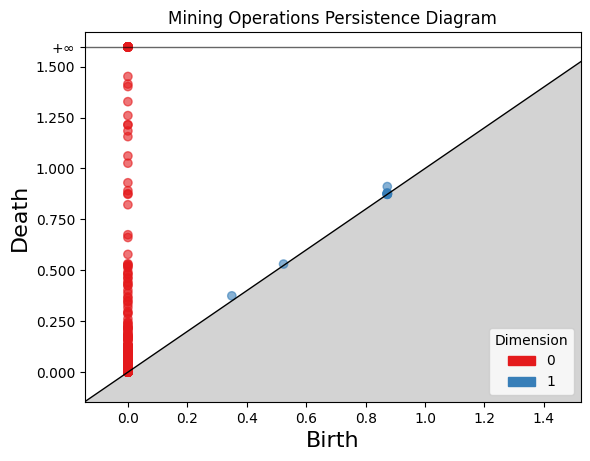

<Figure size 1200x600 with 0 Axes>

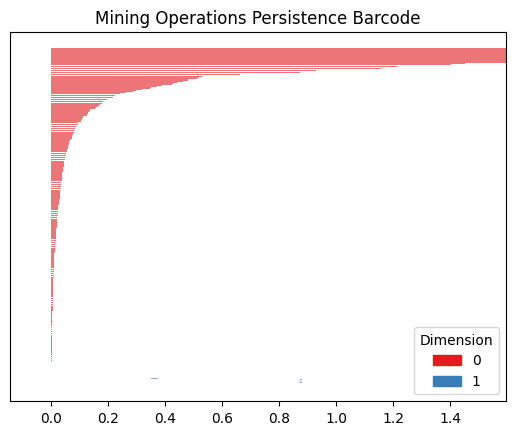

PERSISTENT HOMOLOGY MINING ANALYSIS
H0 features (Connected Components): 500
H1 features (Loops/Tunnels): 10
Significant H1 features (persistence > 0.15): 0
SIMPLE STRUCTURAL PATTERN: Mining operations show linear or star-shaped distribution patterns.
MINING OPERATIONS TOPOLOGICAL INSIGHTS
Topological Analysis:
  28 major mining clusters identified
  96 operational patterns mapped
  Network density: 0.015
Key Mining Patterns:
  23 major operational clusters
  21 high-potential clusters
Commodity Distribution in Clusters:
  Fe: 5 clusters, 314 total mines
  Gp: 3 clusters, 34 total mines
  Gvl: 10 clusters, 421 total mines
  Kln: 1 clusters, 13 total mines
  Sd Gvl: 9 clusters, 73 total mines
  Sd: 10 clusters, 270 total mines
  Gvl Sd: 8 clusters, 199 total mines
  Fe Mag: 1 clusters, 9 total mines
Strategic Recommendations:
  20 high-priority exploration clusters identified
    1. Node_17: Score 77.1, Mines: 150, Top Commodity: Gvl Sd
    2. Node_26: Score 76.7, Mines: 149, Top Commodi

In [5]:
# %% [markdown]
# # COMPLETE Ore-Atlas FOR WESTERN AUSTRALIA MINING ANALYSIS

# %%
# Install required TDA and visualization libraries
!pip install giotto-tda gudhi plotly folium geopandas pyvis scikit-learn contextily mapclassify ipywidgets
print("All required libraries installed!")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster, decomposition
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import folium
from folium import plugins
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Enhanced TDA libraries
try:
    import giotto_tda as gtda
    from gtda.mapper import (
        CubicalCover, OneDimensionalCover, make_mapper_pipeline,
        Projection, Clustering, plot_static_mapper_graph, plot_interactive_mapper_graph
    )
    GIOTTO_AVAILABLE = True
except ImportError:
    GIOTTO_AVAILABLE = False

try:
    import gudhi
    GUDHI_AVAILABLE = True
except ImportError:
    GUDHI_AVAILABLE = False

print("Enhanced TDA Mining Analysis Framework Loaded")

# %%
def load_and_preprocess_mining_data():
    from google.colab import files
    import io
    import chardet

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    print(f"Uploaded file: {filename}")

    def detect_encoding(file_bytes):
        result = chardet.detect(file_bytes)
        encoding = result['encoding']
        confidence = result['confidence']
        print(f"Detected encoding: {encoding} (confidence: {confidence:.2f})")
        return encoding

    def load_csv_with_encoding(file_bytes, filename):
        encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252', 'windows-1252']
        detected_encoding = detect_encoding(file_bytes)
        if detected_encoding:
            encodings_to_try.insert(0, detected_encoding)

        for encoding in encodings_to_try:
            try:
                file_like_object = io.BytesIO(file_bytes)
                data = pd.read_csv(file_like_object, encoding=encoding)
                print(f"Successfully loaded with {encoding} encoding")
                return data
            except Exception:
                continue

        try:
            file_like_object = io.BytesIO(file_bytes)
            data = pd.read_csv(file_like_object, encoding='utf-8', errors='replace')
            print("Loaded with error replacement")
            return data
        except Exception as e:
            print(f"Final attempt failed: {e}")
            raise

    mining_data = load_csv_with_encoding(uploaded[filename], filename)
    print(f"Dataset loaded successfully. Shape: {mining_data.shape}")

    initial_count = len(mining_data)
    mining_data.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
    print(f"Removed {initial_count - len(mining_data)} rows with missing coordinates")

    return mining_data

mining_data = load_and_preprocess_mining_data()

# %%
class RobustMiningFeatureEngineer:
    def engineer_features(self, mining_df):
        df_clean = mining_df.copy()

        center_lat, center_lon = df_clean['LATITUDE'].mean(), df_clean['LONGITUDE'].mean()
        df_clean['Distance_To_Center'] = np.sqrt(
            (df_clean['LATITUDE'] - center_lat)**2 +
            (df_clean['LONGITUDE'] - center_lon)**2
        )

        df_clean = self._engineer_commodity_features(df_clean)
        df_clean = self._engineer_operational_features(df_clean)

        FEATURE_COLUMNS = ['Commodity_Count', 'Operational_Complexity', 'Mineral_Score', 'Distance_To_Center']
        FEATURE_COLUMNS += [col for col in df_clean.columns if col.startswith('Is_')]

        if len(FEATURE_COLUMNS) < 4:
            FEATURE_COLUMNS.extend(['LATITUDE', 'LONGITUDE'])

        X_mining = df_clean[FEATURE_COLUMNS].values
        scaler = preprocessing.StandardScaler()
        X_normalized = scaler.fit_transform(X_mining)

        return df_clean, X_normalized, FEATURE_COLUMNS

    def _engineer_commodity_features(self, df):
        if 'COMMODITIES' not in df.columns:
            df['COMMODITIES'] = 'Unknown'
            df['Commodity_Count'] = 1
            df['Primary_Commodity'] = 'Unknown'
            df['Commodity_Group'] = 'Unknown'
            return df

        df['COMMODITIES'] = df['COMMODITIES'].astype(str).str.replace('�', '', regex=False)
        df['Commodity_Count'] = df['COMMODITIES'].str.count(',') + 1
        df['Commodity_Count'] = df['Commodity_Count'].fillna(1)
        df['Primary_Commodity'] = df['COMMODITIES'].str.split(',').str[0].str.strip()

        commodity_groups = {
            'Precious': ['Au', 'Ag'],
            'Base': ['Cu', 'Zn', 'Pb', 'Ni'],
            'Iron': ['Fe'],
            'Industrial': ['Bx', 'Gp', 'Salt', 'Tlc', 'Grt'],
            'Speciality': ['Li', 'Ta', 'Sn', 'REE'],
            'Construction': ['Agg', 'Sd', 'Lst', 'Gvl']
        }

        def get_commodity_group(commodity_str):
            if pd.isna(commodity_str) or commodity_str == 'nan':
                return 'Unknown'
            commodities = str(commodity_str).split(',')
            for comm in commodities:
                comm = comm.strip()
                for group, items in commodity_groups.items():
                    if comm in items:
                        return group
            return 'Other'

        df['Commodity_Group'] = df['COMMODITIES'].apply(get_commodity_group)
        df['Mineral_Score'] = 0
        df.loc[df['COMMODITIES'].str.contains('Au', na=False), 'Mineral_Score'] += 10
        df.loc[df['COMMODITIES'].str.contains('Ag', na=False), 'Mineral_Score'] += 5
        df.loc[df['COMMODITIES'].str.contains('Cu', na=False), 'Mineral_Score'] += 4
        df.loc[df['COMMODITIES'].str.contains('Ni', na=False), 'Mineral_Score'] += 3
        df.loc[df['COMMODITIES'].str.contains('Li', na=False), 'Mineral_Score'] += 6
        df.loc[df['COMMODITIES'].str.contains('REE', na=False), 'Mineral_Score'] += 7

        if 'Primary_Commodity' in df.columns:
            top_commodities = df['Primary_Commodity'].value_counts().nlargest(12).index.tolist()
            for commodity in top_commodities:
                col_name = f'Is_{commodity.replace(" ", "_").replace("/", "_").replace("�", "")}'
                df[col_name] = (df['Primary_Commodity'] == commodity).astype(int)

        return df

    def _engineer_operational_features(self, df):
        for col in ['SITE_TYPE', 'SUB_TYPE']:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace('�', '', regex=False)
            else:
                df[col] = 'Unknown'

        df['Operational_Complexity'] = 1

        open_pit_mask = df['SITE_TYPE'].str.contains('Open', na=False)
        df.loc[open_pit_mask, 'Operational_Complexity'] = 2

        underground_mask = df['SUB_TYPE'].str.contains('Underground|Decline|Shaft', na=False)
        df.loc[underground_mask, 'Operational_Complexity'] = 3

        complex_mask = open_pit_mask & underground_mask
        df.loc[complex_mask, 'Operational_Complexity'] = 4

        special_mask = df['SUB_TYPE'].str.contains('Pond|Tailings', na=False)
        df.loc[special_mask, 'Operational_Complexity'] = 2

        return df

# %%
def create_mining_map(mining_data):
    """Create an interactive Folium map with mining data"""

    center_lat, center_lon = mining_data['LATITUDE'].mean(), mining_data['LONGITUDE'].mean()

    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=6,
        tiles='OpenStreetMap'
    )

    commodity_colors = {
        'Precious': 'red',
        'Base': 'blue',
        'Iron': 'orange',
        'Industrial': 'green',
        'Speciality': 'purple',
        'Construction': 'brown',
        'Unknown': 'gray',
        'Other': 'gray'
    }

    commodity_groups = {}
    for commodity in commodity_colors.keys():
        commodity_groups[commodity] = folium.FeatureGroup(name=commodity)

    high_potential_group = folium.FeatureGroup(name='High Potential Mines')
    complex_operations_group = folium.FeatureGroup(name='Complex Operations')

    for idx, row in mining_data.iterrows():
        popup_text = f"""
        <b>Mine:</b> {row.get('SHORT_TITLE', 'N/A')}<br>
        <b>Commodities:</b> {row.get('COMMODITIES', 'N/A')}<br>
        <b>Commodity Group:</b> {row.get('Commodity_Group', 'N/A')}<br>
        <b>Mineral Score:</b> {row.get('Mineral_Score', 0):.1f}<br>
        <b>Operational Complexity:</b> {row.get('Operational_Complexity', 1)}<br>
        <b>Commodity Count:</b> {row.get('Commodity_Count', 1)}
        """

        commodity_group = row.get('Commodity_Group', 'Unknown')
        color = commodity_colors.get(commodity_group, 'gray')

        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=6,
            popup=popup_text,
            color=color,
            fill=True,
            fillOpacity=0.7
        ).add_to(commodity_groups[commodity_group])

        if row.get('Mineral_Score', 0) > 8:
            folium.CircleMarker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                radius=10,
                popup=popup_text + "<br><b>HIGH POTENTIAL</b>",
                color='gold',
                fill=True,
                fillOpacity=0.9,
                weight=2
            ).add_to(high_potential_group)

        if row.get('Operational_Complexity', 1) >= 3:
            folium.CircleMarker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                radius=8,
                popup=popup_text + "<br><b>COMPLEX OPERATION</b>",
                color='darkred',
                fill=True,
                fillOpacity=0.8
            ).add_to(complex_operations_group)

    for group in commodity_groups.values():
        group.add_to(m)
    high_potential_group.add_to(m)
    complex_operations_group.add_to(m)

    folium.LayerControl().add_to(m)
    plugins.MeasureControl().add_to(m)

    return m

# Create and display the interactive map
mining_map = create_mining_map(mining_data)
mining_map.save('wa_mining_operations_map.html')
print("Interactive map saved as 'wa_mining_operations_map.html'")

# %%
class EnhancedMiningMapper:
    def __init__(self, n_intervals=10, overlap=0.3, n_clusters=5):
        self.n_intervals = n_intervals
        self.overlap = overlap
        self.n_clusters = n_clusters
        self.graph = None
        self.node_info = {}

    def _calculate_node_statistics(self, node_indices, original_data):
        node_data = original_data.iloc[node_indices]

        top_commodity = node_data['Primary_Commodity'].mode()
        top_commodity = top_commodity[0] if not top_commodity.empty else 'N/A'

        commodity_group_dist = node_data['Commodity_Group'].value_counts()
        avg_complexity = node_data['Operational_Complexity'].mean()
        max_complexity = node_data['Operational_Complexity'].max()

        stats = {
            'size': len(node_indices),
            'mean_mineral_score': float(node_data['Mineral_Score'].mean()),
            'max_mineral_score': float(node_data['Mineral_Score'].max()),
            'mean_complexity': float(avg_complexity),
            'max_complexity': int(max_complexity),
            'commodity_diversity': float(node_data['Commodity_Count'].mean()),
            'top_commodity': top_commodity,
            'commodity_groups': commodity_group_dist.to_dict(),
            'spatial_extent': {
                'min_lat': float(node_data['LATITUDE'].min()),
                'max_lat': float(node_data['LATITUDE'].max()),
                'min_lon': float(node_data['LONGITUDE'].min()),
                'max_lon': float(node_data['LONGITUDE'].max())
            }
        }

        stats['mining_potential'] = (
            stats['mean_mineral_score'] * 0.4 +
            stats['mean_complexity'] * 20 +
            stats['commodity_diversity'] * 10
        )

        return stats

    def fit(self, X, lens_function, original_data):
        self.X = X
        self.original_data = original_data
        self.n_samples = X.shape[0]

        self.lens = lens_function(X, original_data) if lens_function is not None else X[:, 0]

        self._create_intervals()
        self._build_enhanced_mapper_graph(original_data)

        return self

    def _create_intervals(self):
        lens_min, lens_max = self.lens.min(), self.lens.max()
        interval_range = lens_max - lens_min
        interval_length = interval_range / self.n_intervals
        overlap_length = interval_length * self.overlap

        self.intervals = []
        for i in range(self.n_intervals):
            start = lens_min + i * (interval_length - overlap_length)
            end = start + interval_length
            self.intervals.append((start, end))

    def _build_enhanced_mapper_graph(self, original_data):
        self.graph = nx.Graph()
        node_id = 0

        index_to_nodes = {i: [] for i in range(self.n_samples)}

        for i, (start, end) in enumerate(self.intervals):
            in_interval = (self.lens >= start) & (self.lens <= end)
            interval_indices = np.where(in_interval)[0]

            if len(interval_indices) < 2:
                continue

            interval_data = self.X[interval_indices]
            n_clusters = min(self.n_clusters, len(interval_indices) // 3, 15)

            if n_clusters < 2:
                continue

            kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(interval_data)

            for cluster_id in range(n_clusters):
                cluster_indices = interval_indices[cluster_labels == cluster_id]

                if len(cluster_indices) > 0:
                    node_name = f"Node_{node_id}"
                    self.graph.add_node(node_name)

                    stats = self._calculate_node_statistics(cluster_indices, original_data)

                    self.node_info[node_name] = {
                        'interval': i,
                        'cluster': cluster_id,
                        'indices': cluster_indices,
                        'lens_value': np.mean(self.lens[cluster_indices]),
                        'statistics': stats
                    }

                    for idx in cluster_indices:
                        index_to_nodes[idx].append(node_name)

                    node_id += 1

        self._connect_nodes(index_to_nodes)

    def _connect_nodes(self, index_to_nodes):
        edges = {}
        for node_list in index_to_nodes.values():
            for i in range(len(node_list)):
                for j in range(i + 1, len(node_list)):
                    n1, n2 = sorted([node_list[i], node_list[j]])
                    edges[(n1, n2)] = edges.get((n1, n2), 0) + 1

        for (n1, n2), weight in edges.items():
            self.graph.add_edge(n1, n2, weight=weight)

    def visualize_interactive_mapper(self, title="Interactive Mining Mapper Graph"):
        if not self.graph or not self.graph.nodes():
            print("No graph to visualize. Fit the mapper first or check input data.")
            return

        pos = {node: [info['lens_value'], info['interval']] for node, info in self.node_info.items()}

        edge_x, edge_y = [], []
        for edge in self.graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='#888'),
            hoverinfo='none',
            mode='lines'
        )

        node_x, node_y, node_text, node_size, node_color = [], [], [], [], []
        for node in self.graph.nodes():
            info = self.node_info[node]
            stats = info['statistics']

            node_x.append(pos[node][0])
            node_y.append(pos[node][1])
            node_size.append(stats['size'] ** 0.5 * 3)
            node_color.append(stats['mining_potential'])

            hover_text = (
                f"<b>{node} ({stats['top_commodity']})</b><br>"
                f"Size: {stats['size']} mines<br>"
                f"Avg Mineral Score: {stats['mean_mineral_score']:.1f}<br>"
                f"Complexity: {stats['mean_complexity']:.1f}<br>"
                f"Commodity Diversity: {stats['commodity_diversity']:.1f}<br>"
                f"Mining Potential: {stats['mining_potential']:.1f}"
            )
            node_text.append(hover_text)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            hoverinfo='text',
            text=[f"{i}" for i in range(len(node_x))],
            textposition="middle center",
            marker=dict(
                size=node_size,
                sizemode='area',
                sizeref=2.*max(node_size)/(40.**2),
                sizemin=8,
                color=node_color,
                colorscale='YlOrRd',
                colorbar=dict(title='Mining Potential'),
                line=dict(width=2, color='darkred')
            ),
            textfont=dict(size=10, color='white'),
            hovertext=node_text
        )

        fig = go.Figure(
            data=[edge_trace, node_trace],
            layout=go.Layout(
                title=dict(text=title, x=0.5, xanchor='center'),
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=True, zeroline=False, showticklabels=True, title='Filter Function Value'),
                yaxis=dict(showgrid=True, zeroline=False, showticklabels=True, title='Interval Index'),
                width=800,
                height=600
            )
        )

        fig.write_html("interactive_mining_mapper_graph.html")
        print("Interactive Mining Mapper Graph saved as 'interactive_mining_mapper_graph.html'")
        return fig

    def create_node_map(self, original_data):
        if not self.graph or not self.graph.nodes():
            print("No graph to map.")
            return

        node_index_map = {}
        for node_id, (node, info) in enumerate(self.node_info.items()):
            original_df_indices = original_data.index[info['indices']]
            for original_idx in original_df_indices:
                 node_index_map[original_idx] = node_id

        cmap = plt.cm.get_cmap('tab10', len(self.node_info))
        node_color_map = {}
        for node_id, node_name in enumerate(self.node_info.keys()):
            rgb = cmap(node_id % 10)
            node_color_map[node_name] = f'rgb({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)})'

        m = folium.Map(
            location=[original_data['LATITUDE'].mean(), original_data['LONGITUDE'].mean()],
            zoom_start=6
        )

        for idx, row in original_data.iterrows():
            node_idx = node_index_map.get(idx, -1)

            if node_idx != -1:
                node_name = list(self.node_info.keys())[node_idx]
                stats = self.node_info[node_name]['statistics']
                color = node_color_map[node_name]

                popup_text = f"""
                <b>Node {node_idx} ({node_name})</b><br>
                <b>Mine:</b> {row.get('SHORT_TITLE', 'N/A')}<br>
                <b>Commodities:</b> {row.get('COMMODITIES', 'N/A')}<br>
                <b>Mineral Score:</b> {row.get('Mineral_Score', 0):.1f}<br>
                <b>Node Avg Score:</b> {stats['mean_mineral_score']:.1f}<br>
                <b>Top Commodity:</b> {stats['top_commodity']}<br>
                <b>Cluster Size:</b> {stats['size']} mines
                """

                folium.CircleMarker(
                    location=[row['LATITUDE'], row['LONGITUDE']],
                    radius=5,
                    popup=popup_text,
                    color=color,
                    fill=True,
                    fillOpacity=0.7
                ).add_to(m)

        folium.LayerControl().add_to(m)
        m.save('mining_node_assignments_map.html')
        print("Node assignment map saved as 'mining_node_assignments_map.html'")
        return m

# %%
class MiningPersistentHomology:
    def __init__(self, max_edge_length=1.5, max_sample_size=500):
        self.max_edge_length = max_edge_length
        self.max_sample_size = max_sample_size

    def compute_persistence(self, X, homology_dimensions=(0, 1, 2)):
        if not GUDHI_AVAILABLE:
            print("GUDHI not available. Skipping persistent homology.")
            return None, None

        print("Computing Persistent Homology (Rips Complex)...")

        if X.shape[0] > self.max_sample_size:
            np.random.seed(42)
            subset_indices = np.random.choice(X.shape[0], size=self.max_sample_size, replace=False)
            X_subset = X[subset_indices]
            print(f"Sampling {len(X_subset)} points for PH analysis...")
        else:
            X_subset = X

        try:
            rips_complex = gudhi.RipsComplex(
                points=X_subset,
                max_edge_length=self.max_edge_length
            )

            simplex_tree = rips_complex.create_simplex_tree(
                max_dimension=max(homology_dimensions) + 1
            )

            persistence = simplex_tree.persistence()
            return persistence, simplex_tree
        except Exception as e:
            print(f"Error in persistent homology computation: {e}")
            return None, None

    def plot_persistence_diagram(self, persistence, title="Persistence Diagram"):
        if persistence is None:
            return

        plt.figure(figsize=(10, 6))
        gudhi.plot_persistence_diagram(persistence)
        plt.title(title)
        plt.show()

    def plot_persistence_barcode(self, persistence, title="Persistence Barcode"):
        if persistence is None:
            return

        plt.figure(figsize=(12, 6))
        gudhi.plot_persistence_barcode(persistence)
        plt.title(title)
        plt.show()

    def analyze_mining_features(self, persistence, threshold=0.15):
        if persistence is None:
            return

        print("PERSISTENT HOMOLOGY MINING ANALYSIS")

        h0 = [(birth, death) for dim, (birth, death) in persistence if dim == 0]
        h1 = [(birth, death) for dim, (birth, death) in persistence if dim == 1]

        significant_h1 = [(b, d) for b, d in h1 if (d - b) > threshold]

        print(f"H0 features (Connected Components): {len(h0)}")
        print(f"H1 features (Loops/Tunnels): {len(h1)}")
        print(f"Significant H1 features (persistence > {threshold}): {len(significant_h1)}")

        if len(significant_h1) > 3:
            print("HIGH STRUCTURAL COMPLEXITY: Multiple persistent loops suggest complex mining districts with interconnected operations.")
        elif len(significant_h1) > 0:
            print("MODERATE STRUCTURAL COMPLEXITY: Indicates regional clustering with some operational interdependencies.")
        else:
            print("SIMPLE STRUCTURAL PATTERN: Mining operations show linear or star-shaped distribution patterns.")

# %%
def mining_spatial_operational_lens(X, original_data):
    distance = original_data['Distance_To_Center'].values
    distance_scaled = (distance - distance.min()) / (distance.max() - distance.min())

    operational_score = (
        original_data['Operational_Complexity'].values / 4.0 +
        original_data['Mineral_Score'].values / original_data['Mineral_Score'].max()
    ) / 2.0

    operational_scaled = (operational_score - operational_score.min()) / (operational_score.max() - operational_score.min())

    return 0.5 * distance_scaled + 0.5 * operational_scaled

# %%
def generate_mining_insights(mapper, persistence, mining_data):
    print("MINING OPERATIONS TOPOLOGICAL INSIGHTS")

    components = list(nx.connected_components(mapper.graph))
    node_sizes = [info['statistics']['size'] for info in mapper.node_info.values()]

    print(f"Topological Analysis:")
    print(f"  {len(components)} major mining clusters identified")
    print(f"  {len(mapper.graph.nodes())} operational patterns mapped")
    print(f"  Network density: {nx.density(mapper.graph):.3f}")

    large_clusters = [node for node, info in mapper.node_info.items()
                     if info['statistics']['size'] > np.percentile(node_sizes, 75)]

    high_potential_nodes = [node for node, info in mapper.node_info.items()
                           if info['statistics']['mining_potential'] > np.percentile(
                               [n['statistics']['mining_potential'] for n in mapper.node_info.values()], 75)]

    print(f"Key Mining Patterns:")
    print(f"  {len(large_clusters)} major operational clusters")
    print(f"  {len(high_potential_nodes)} high-potential clusters")

    commodity_patterns = {}
    for node, info in mapper.node_info.items():
        top_comm = info['statistics']['top_commodity']
        if top_comm not in commodity_patterns:
            commodity_patterns[top_comm] = []
        commodity_patterns[top_comm].append((node, info['statistics']['size']))

    print(f"Commodity Distribution in Clusters:")
    for commodity, nodes in list(commodity_patterns.items())[:8]:
        total_mines = sum(size for _, size in nodes)
        print(f"  {commodity}: {len(nodes)} clusters, {total_mines} total mines")

    print(f"Strategic Recommendations:")

    promising_clusters = []
    for node, info in mapper.node_info.items():
        stats = info['statistics']

        cluster_score = (
            stats['mining_potential'] * 0.4 +
            stats['size'] * 0.3 +
            stats['commodity_diversity'] * 20
        )

        if cluster_score > 40 and stats['size'] > 8:
            promising_clusters.append((node, cluster_score, stats))

    if promising_clusters:
        print(f"  {len(promising_clusters)} high-priority exploration clusters identified")
        promising_clusters.sort(key=lambda x: x[1], reverse=True)

        for i, (node, score, stats) in enumerate(promising_clusters[:3]):
            print(f"    {i+1}. {node}: Score {score:.1f}, Mines: {stats['size']}, Top Commodity: {stats['top_commodity']}")

    if persistence:
        h1_count = len([(b,d) for dim, (b,d) in persistence if dim == 1 and (d-b) > 0.15])
        print(f"Structural Analysis:")
        print(f"  {h1_count} significant topological loops detected")
        print(f"  Indicates interconnected mining districts")

# %%
print("EXECUTING COMPLETE ENHANCED TDA PIPELINE")

feature_engineer = RobustMiningFeatureEngineer()
mining_data_enhanced, X_normalized, feature_columns = feature_engineer.engineer_features(mining_data)

print("Creating Mining Operations Map...")
mining_map = create_mining_map(mining_data_enhanced)

print("Fitting Enhanced Mining Mapper...")
mining_mapper = EnhancedMiningMapper(n_intervals=12, overlap=0.35, n_clusters=8)
mining_mapper.fit(X_normalized, lens_function=mining_spatial_operational_lens, original_data=mining_data_enhanced)

print("Creating Interactive Mapper Visualization...")
mapper_fig = mining_mapper.visualize_interactive_mapper(
    title="Mining Operations Mapper - Spatial-Operational Structure"
)

print("Creating Node Assignment Map...")
node_map = mining_mapper.create_node_map(mining_data_enhanced)

print("Computing Persistent Homology...")
if GUDHI_AVAILABLE:
    ph_analyzer = MiningPersistentHomology(max_edge_length=1.5, max_sample_size=500)
    persistence, simplex_tree = ph_analyzer.compute_persistence(X_normalized)

    if persistence:
        ph_analyzer.plot_persistence_diagram(persistence, "Mining Operations Persistence Diagram")
        ph_analyzer.plot_persistence_barcode(persistence, "Mining Operations Persistence Barcode")
        ph_analyzer.analyze_mining_features(persistence, threshold=0.15)
else:
    persistence = None

generate_mining_insights(mining_mapper, persistence, mining_data_enhanced)

# %%
print("FINAL RESULTS SUMMARY")
print(f"Total mines analyzed: {len(mining_data_enhanced)}")
print(f"Geographic coverage:")
print(f"  Latitude: {mining_data_enhanced['LATITUDE'].min():.2f} to {mining_data_enhanced['LATITUDE'].max():.2f}")
print(f"  Longitude: {mining_data_enhanced['LONGITUDE'].min():.2f} to {mining_data_enhanced['LONGITUDE'].max():.2f}")

if 'Commodity_Group' in mining_data_enhanced.columns:
    print(f"Commodity Group Distribution:")
    for group, count in mining_data_enhanced['Commodity_Group'].value_counts().items():
        print(f"  {group}: {count} mines")

if 'Operational_Complexity' in mining_data_enhanced.columns:
    print(f"Operational Complexity:")
    for complexity, count in mining_data_enhanced['Operational_Complexity'].value_counts().sort_index().items():
        level = {1: 'Basic', 2: 'Open Pit', 3: 'Underground', 4: 'Complex'}.get(complexity, 'Unknown')
        print(f"  {level}: {count} mines")

print(f"Mineral Score Statistics:")
print(f"  Average: {mining_data_enhanced['Mineral_Score'].mean():.1f}")
print(f"  Maximum: {mining_data_enhanced['Mineral_Score'].max():.1f}")
print(f"  Mines with score > 5: {(mining_data_enhanced['Mineral_Score'] > 5).sum()}")

print("Analysis complete. Ready for strategic mining analysis and exploration planning.")